In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

In [ ]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
"""CLASSIFIER FREE-GUIDANCE
class ScoreNetCFG: Classifier-Free Guidance variant of the ScoreNet
class DDPMCGF: DDPM class for Classifier-Free Guidance"""

# Classifier-Free Guidance variant of the ScoreNet
class ScoreNetCFG(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture
  that accepts a label y (digit):
  label y: in [0,...,10] where 10 = 'null' (unconditional)
  The label will be embedded and incorporated to the network
  similarly to how time embeddings are incorporated."""

  def __init__(self, marginal_prob_std,
               num_classes = 11, # 10 digits + 1 'null'
               label_embed_dim = 64, # dimension for label embedding
               channels = [32, 64, 128, 256],
               embed_dim = 256):

    super().__init__()

    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    # Label embedding
    self.embed_label = nn.Embedding(num_classes, label_embed_dim)
    # Unifying label_embed_dim and embed_dim into single dimension
    # for feeding downstream, a fully-connected layer for linearly combining time and label information
    self.fc_embed = nn.Linear(embed_dim + label_embed_dim, embed_dim)

    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y):
    """
    x: images of shape (N, 1, H, W)
    t: time indices shaped (N,) in [0,...,1]
    y: labels shaped (N,) in [0,...,10] where 10 - 'null'. """

    # Time and label embeddings
    embed_t = self.act(self.embed(t))
    embed_y = self.embed_label(y)

    # Combined time + label embeddings
    embed_ty = torch.cat([embed_t, embed_y], dim = 1)
    embed_ty = self.act(self.fc_embed(embed_ty))

    # Encoding
    h1 = self.conv1(x)
    h1 += self.dense1(embed_ty)
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)

    h2 = self.conv2(h1)
    h2 += self.dense2(embed_ty)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2)
    h3 += self.dense3(embed_ty)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed_ty)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding
    h = self.tconv4(h4)
    h += self.dense5(embed_ty)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed_ty)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed_ty)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016,
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

Training:   0%|          | 0/23500 [00:00<?, ?it/s]

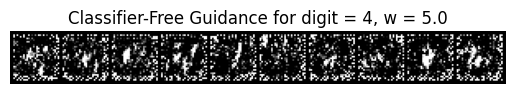

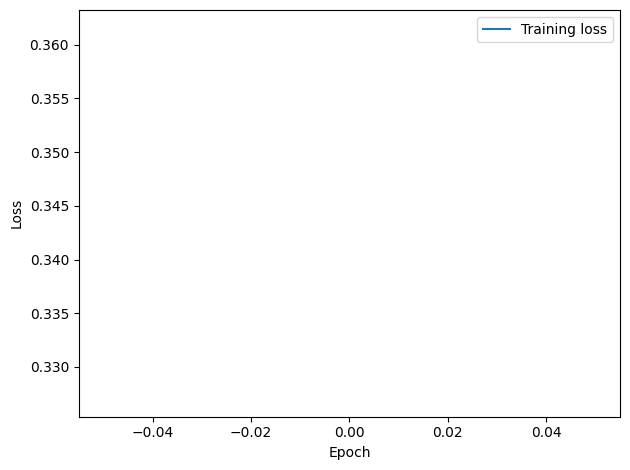

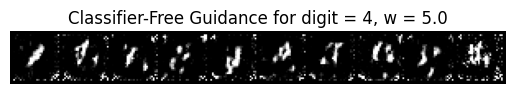

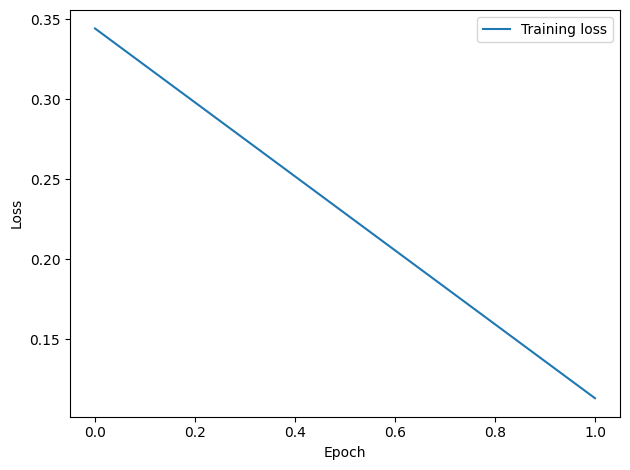

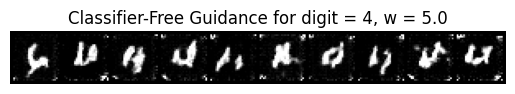

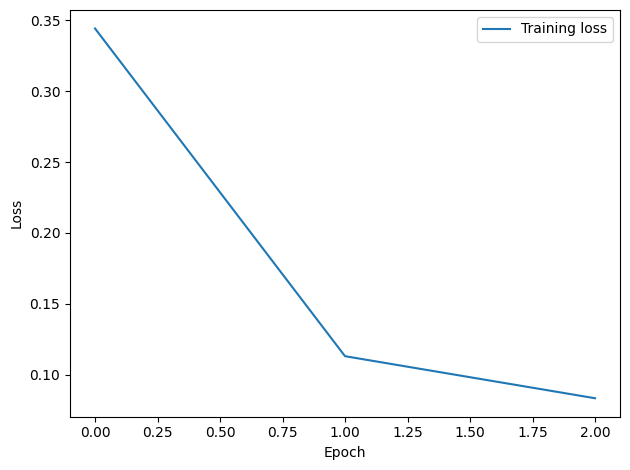

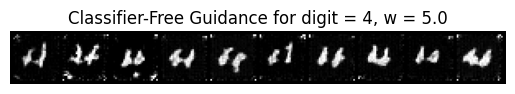

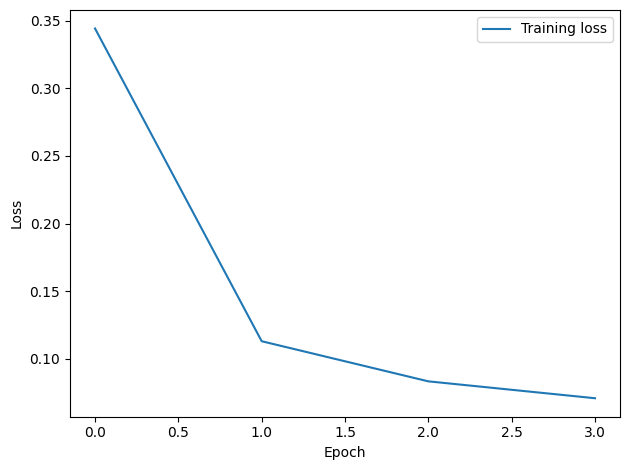

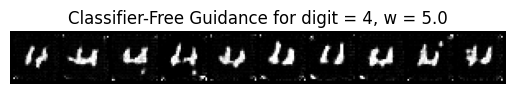

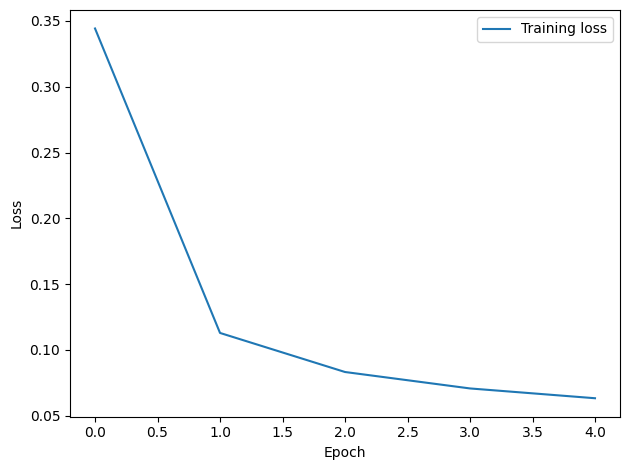

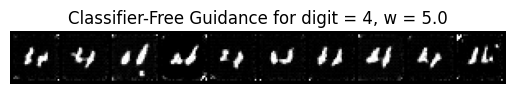

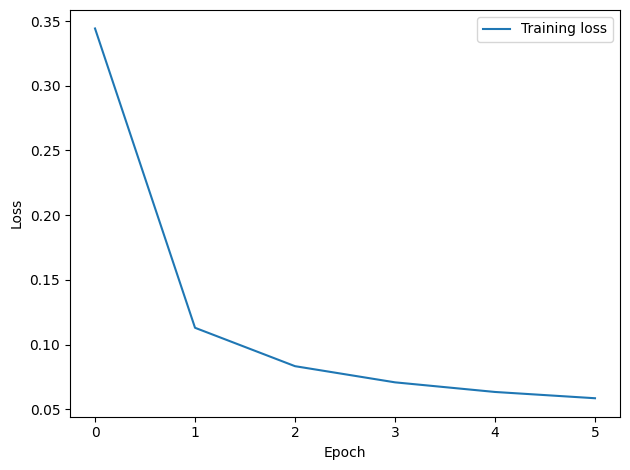

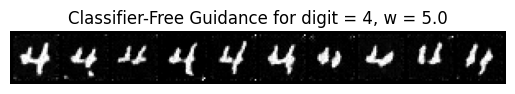

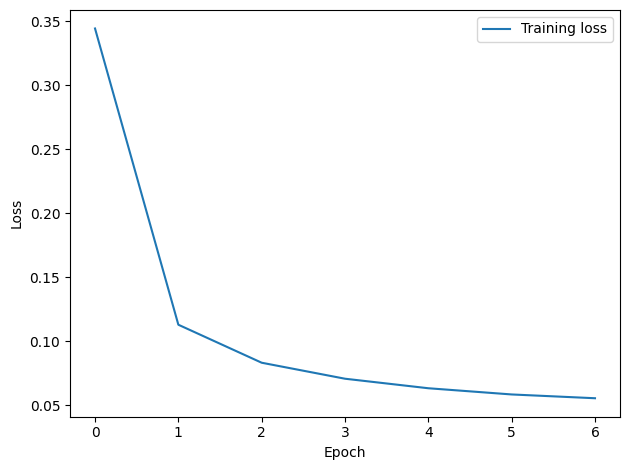

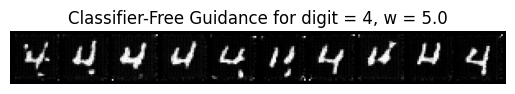

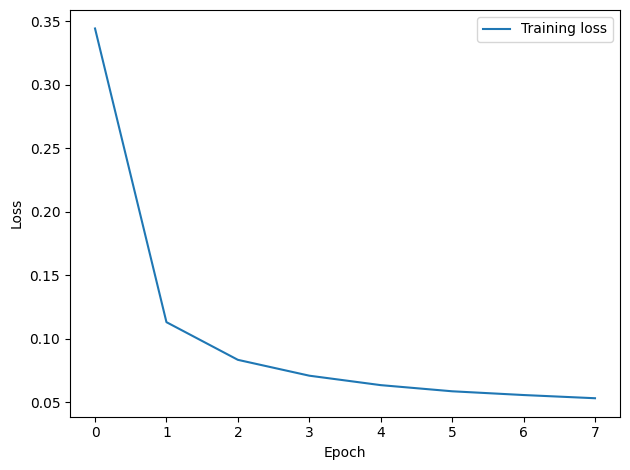

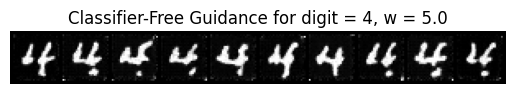

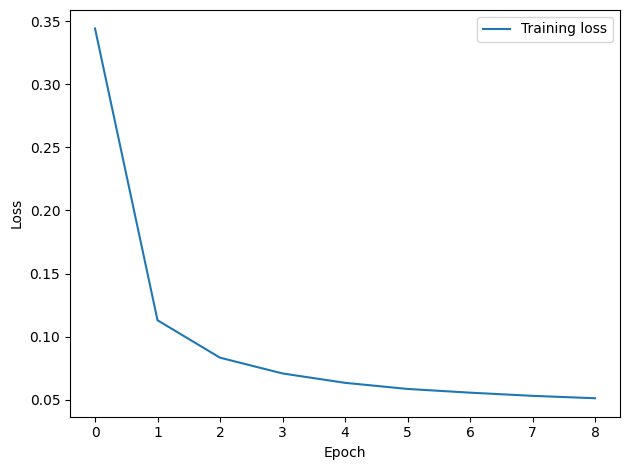

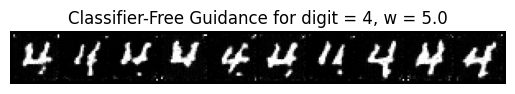

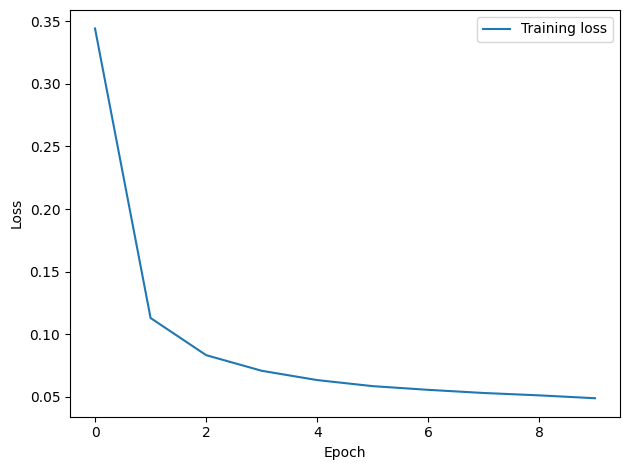

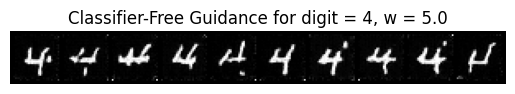

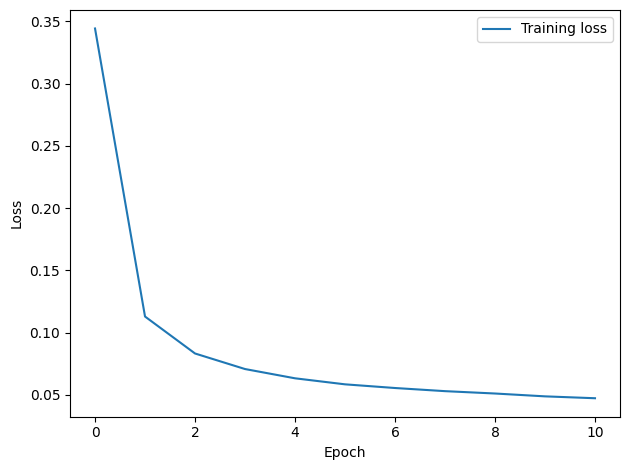

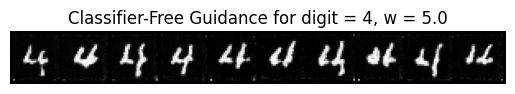

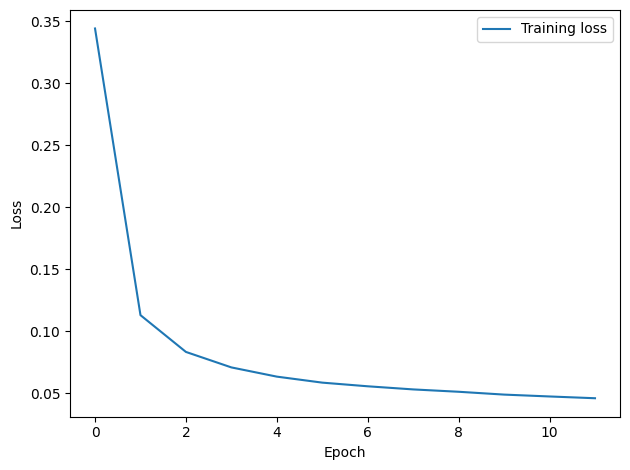

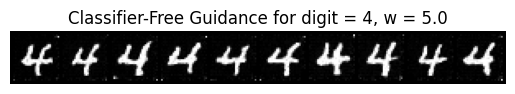

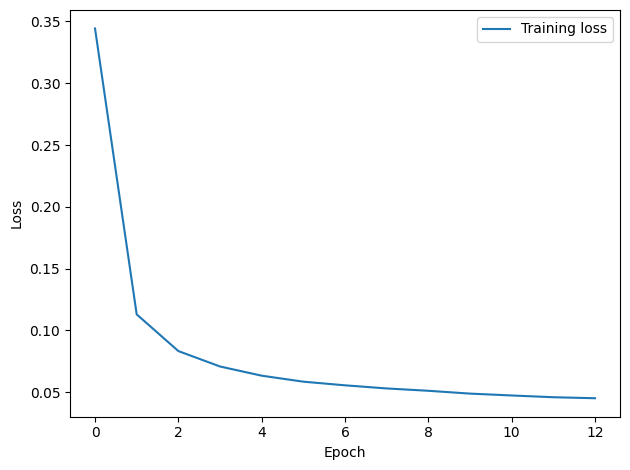

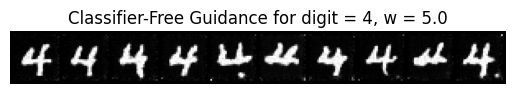

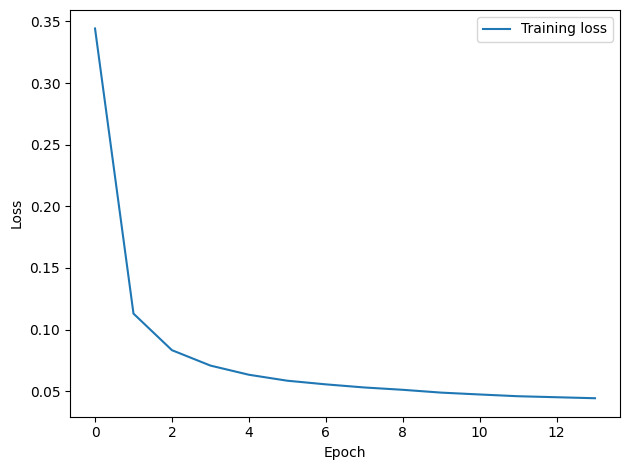

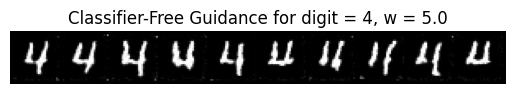

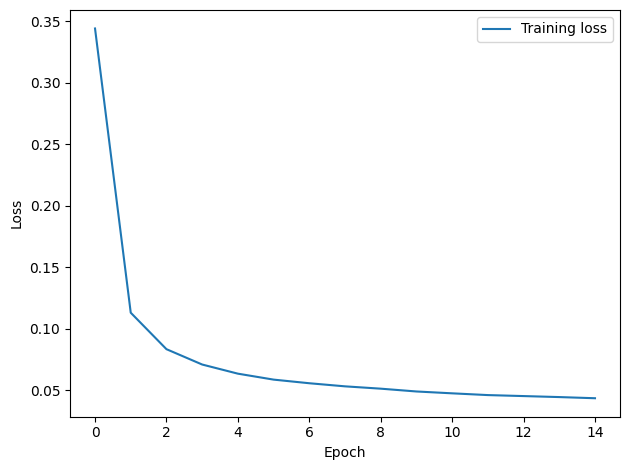

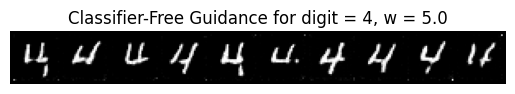

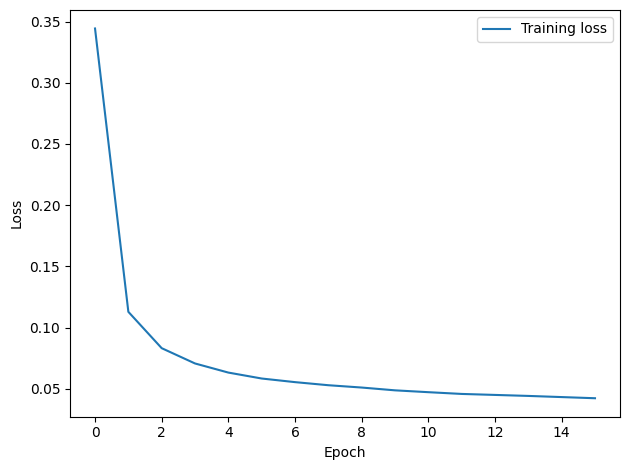

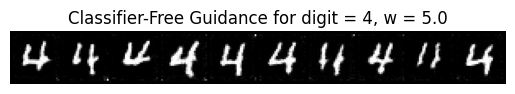

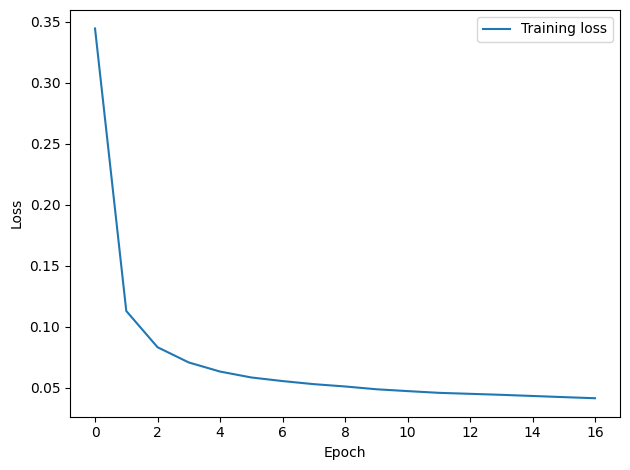

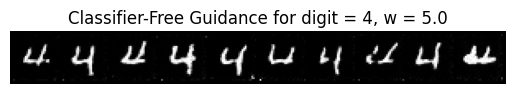

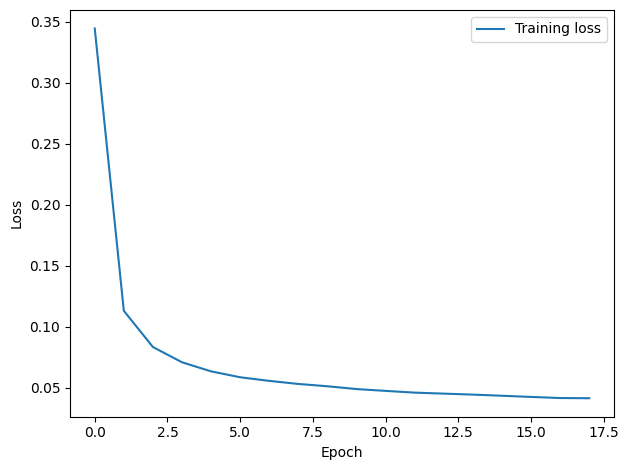

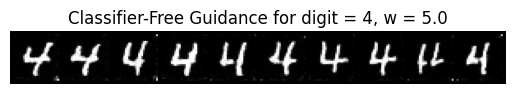

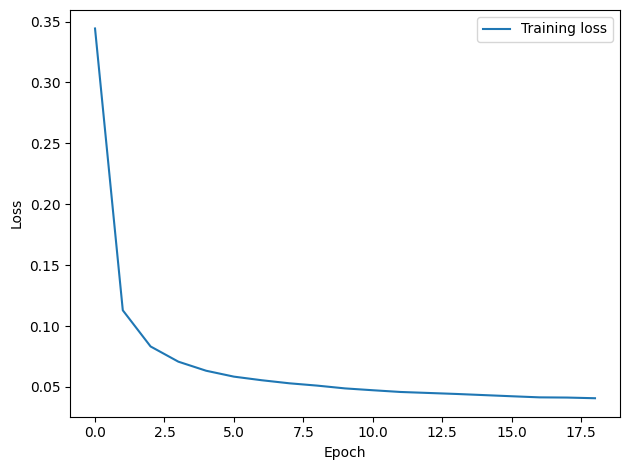

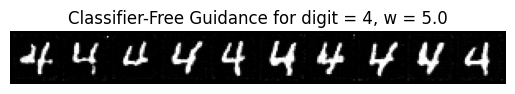

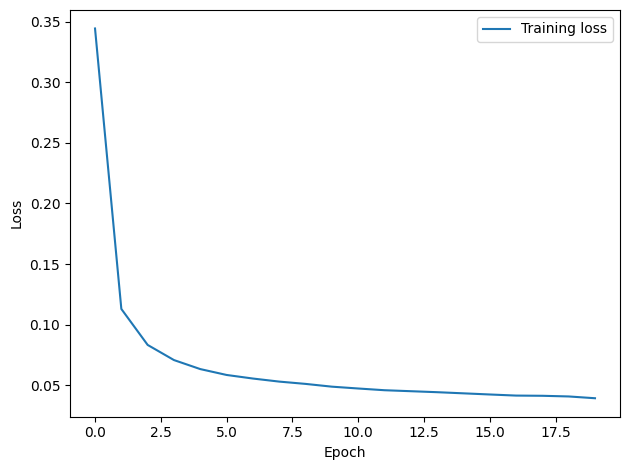

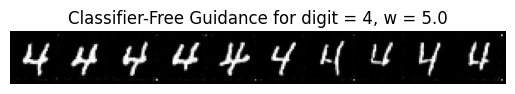

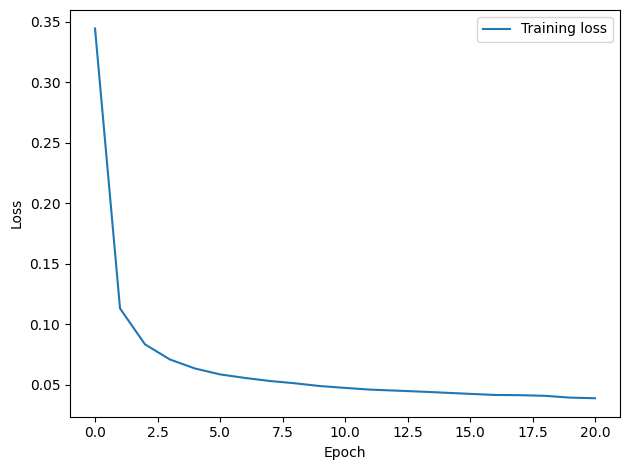

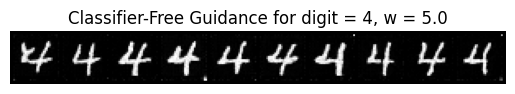

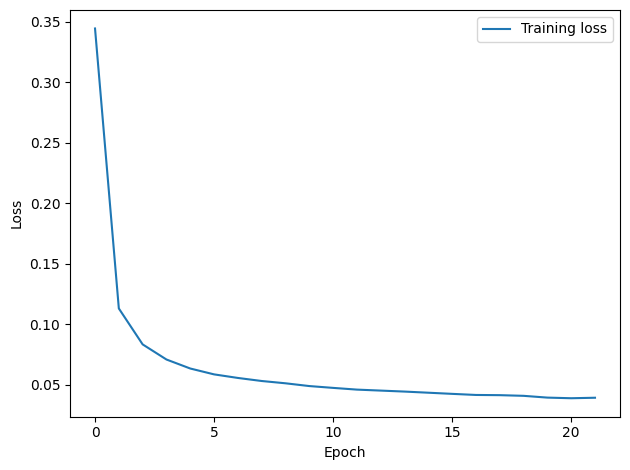

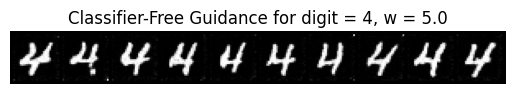

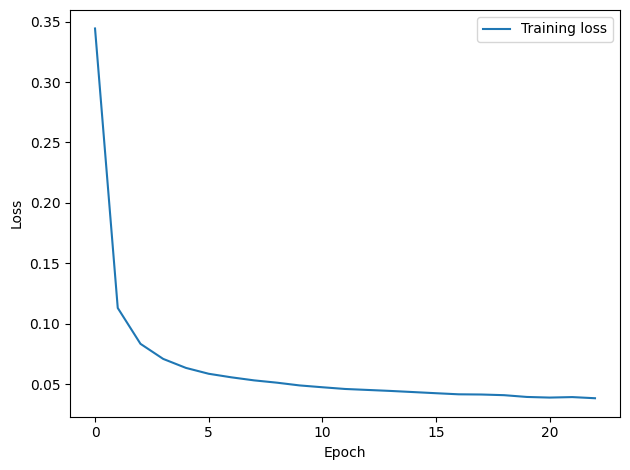

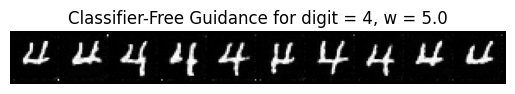

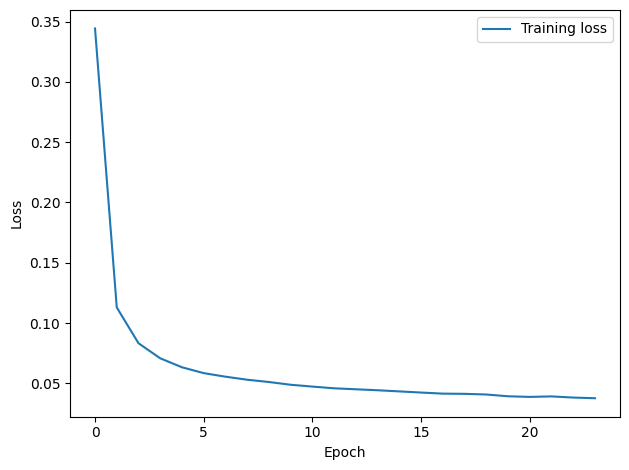

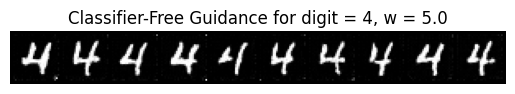

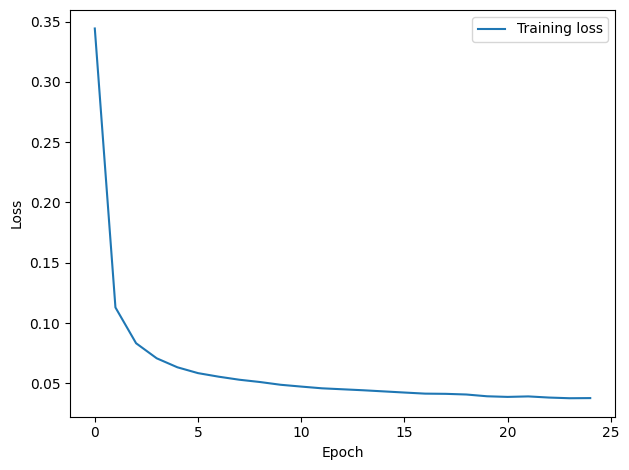

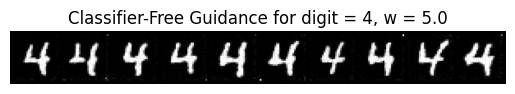

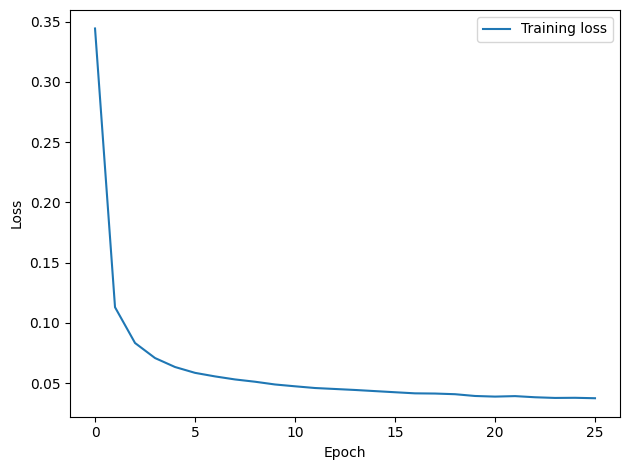

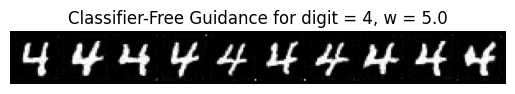

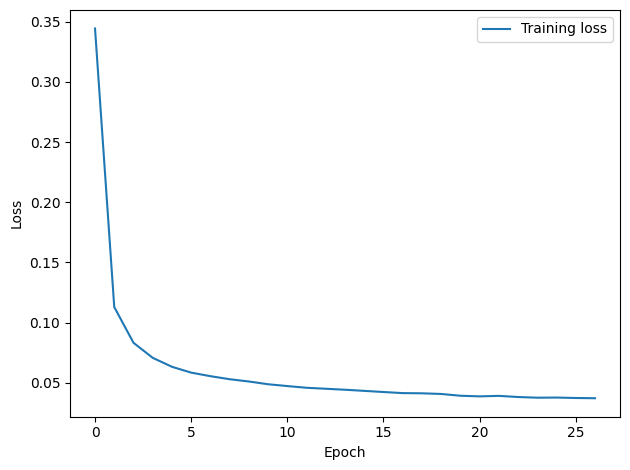

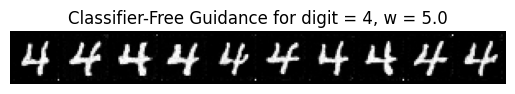

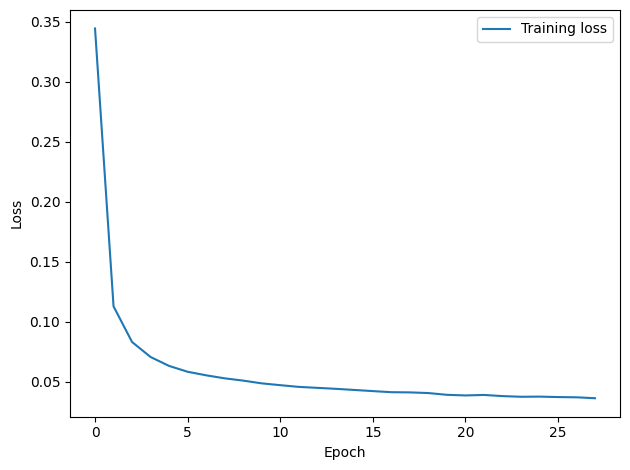

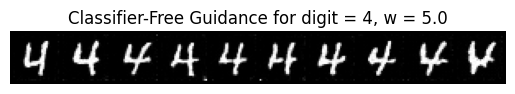

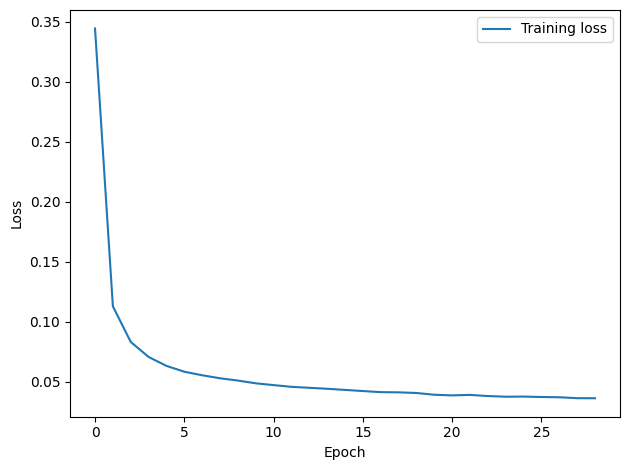

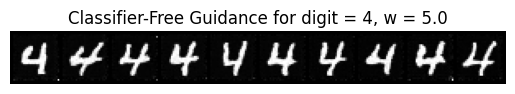

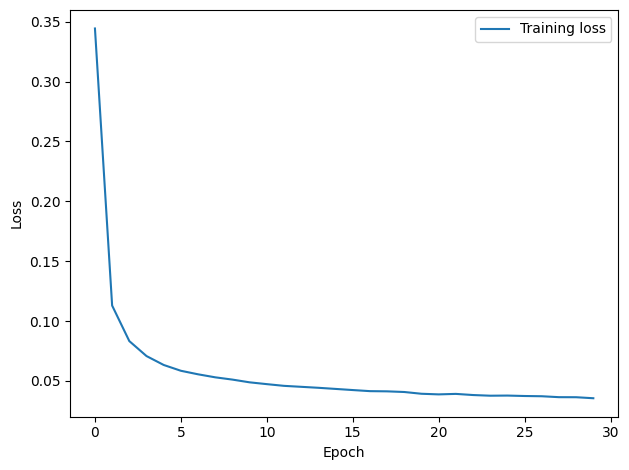

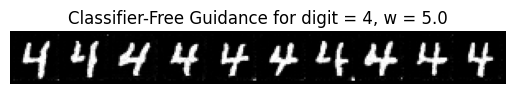

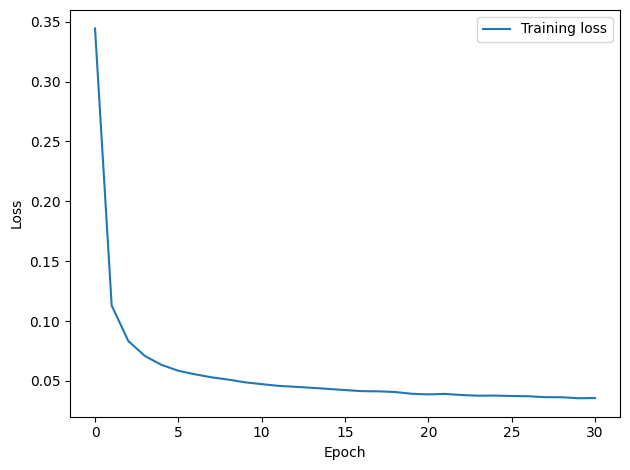

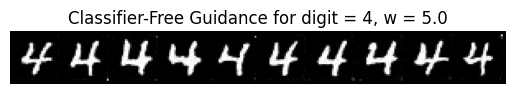

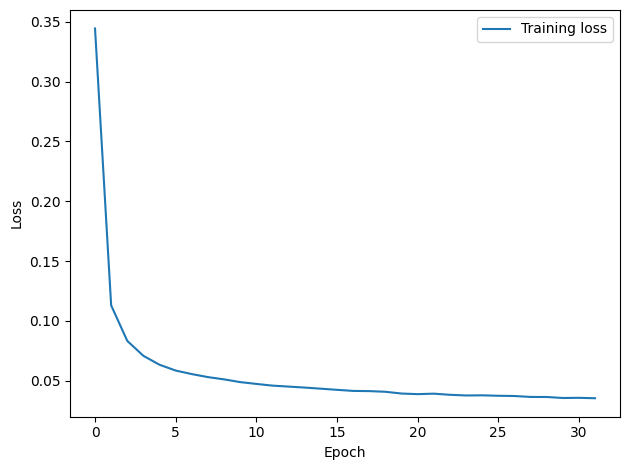

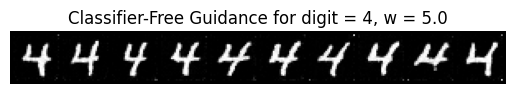

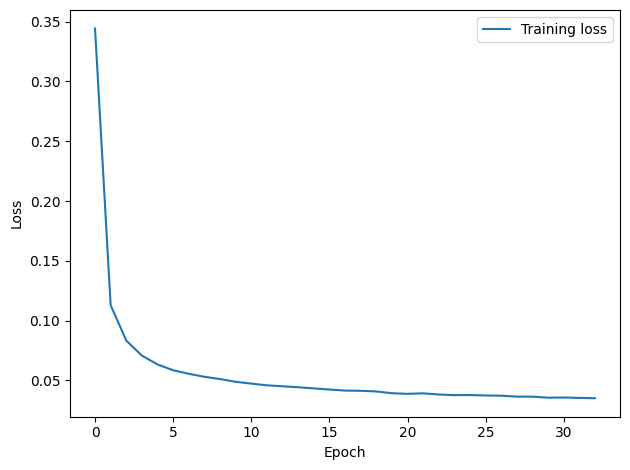

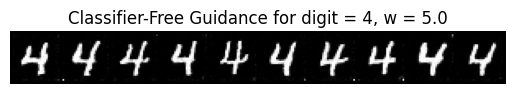

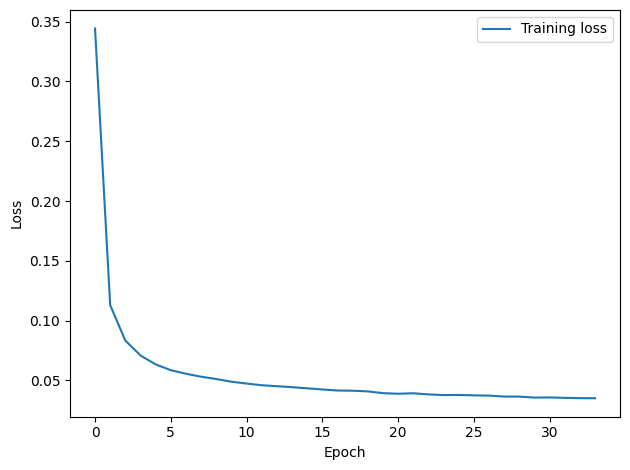

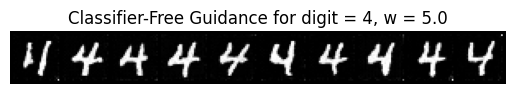

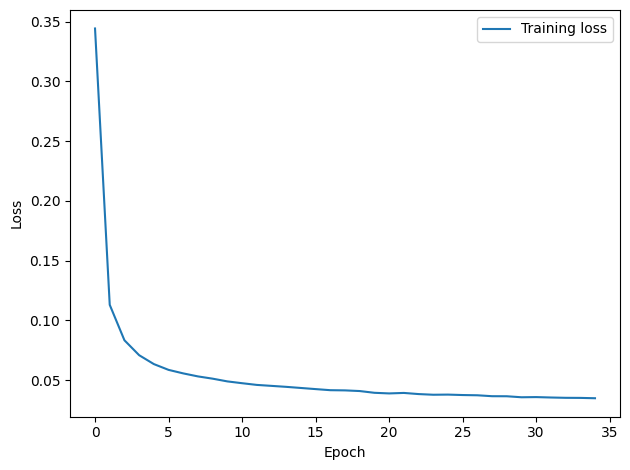

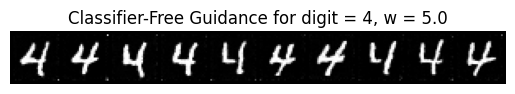

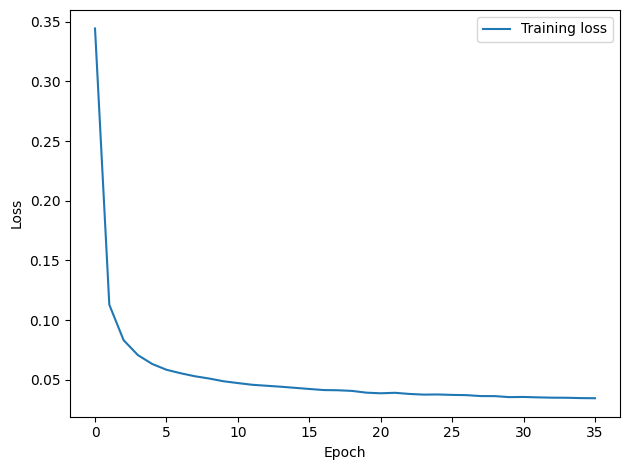

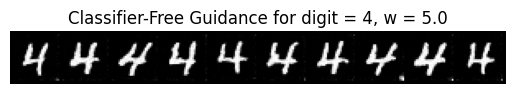

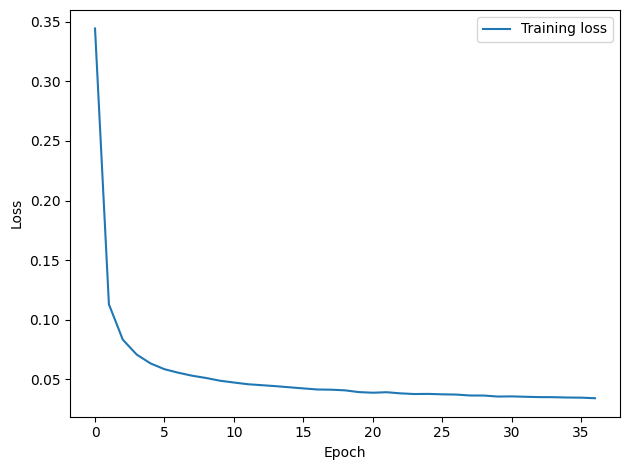

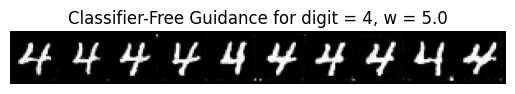

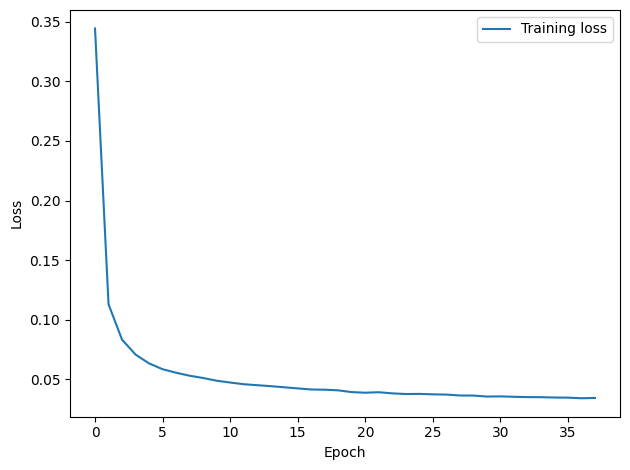

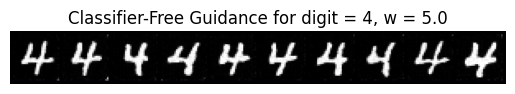

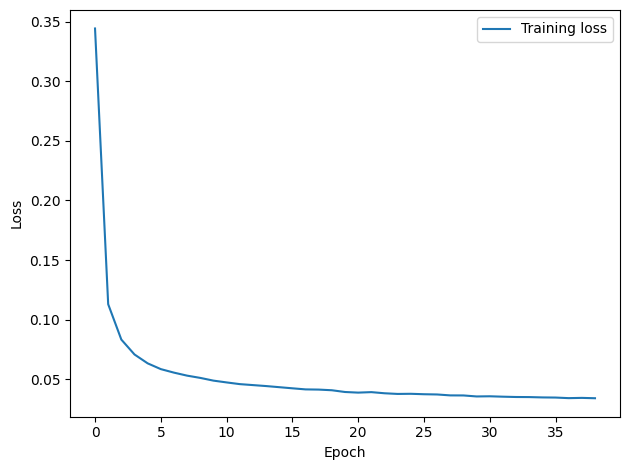

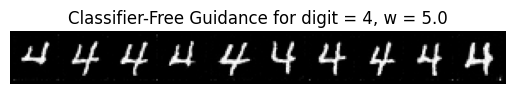

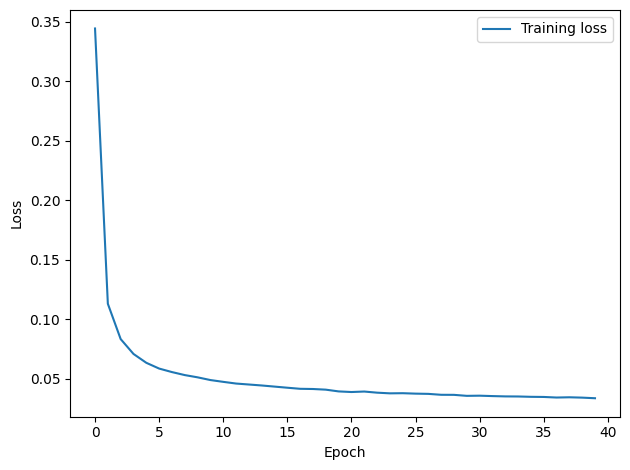

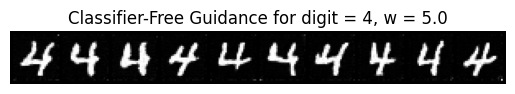

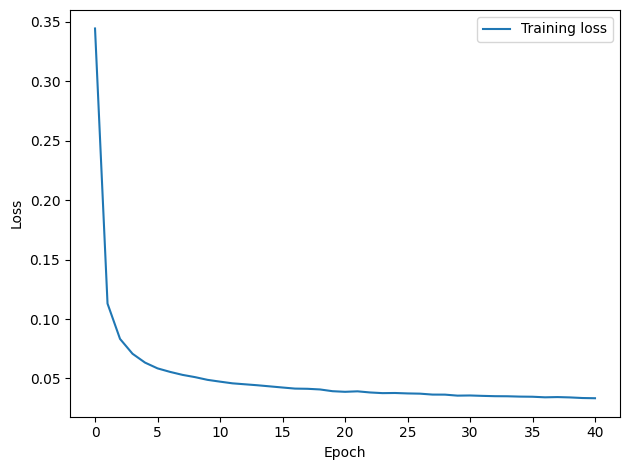

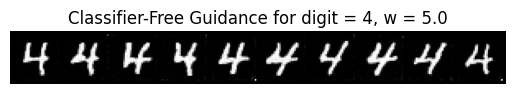

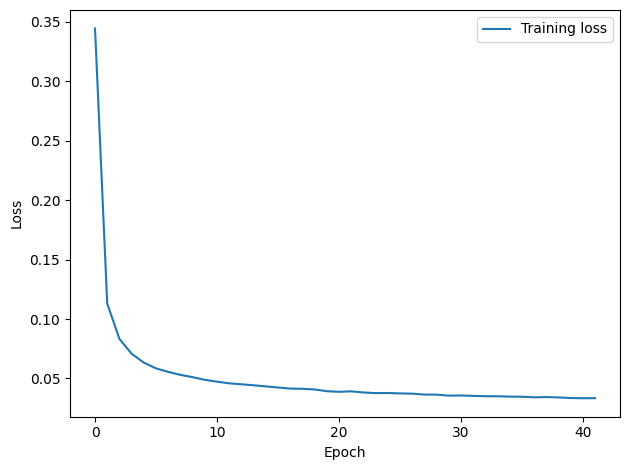

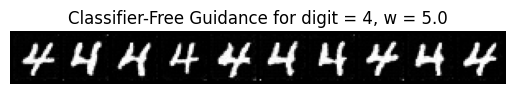

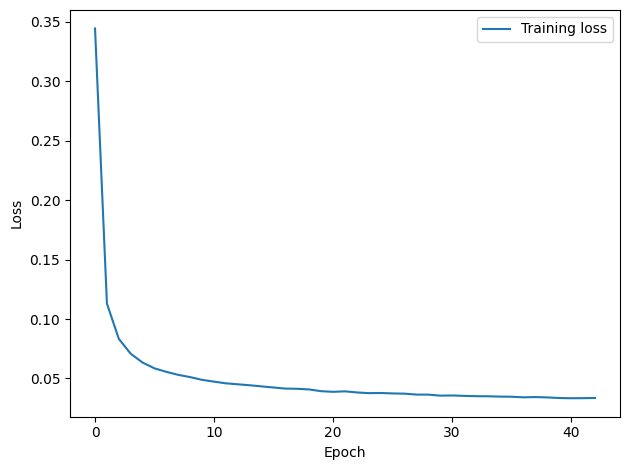

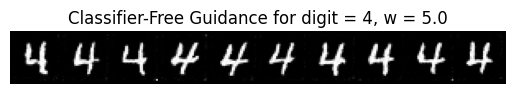

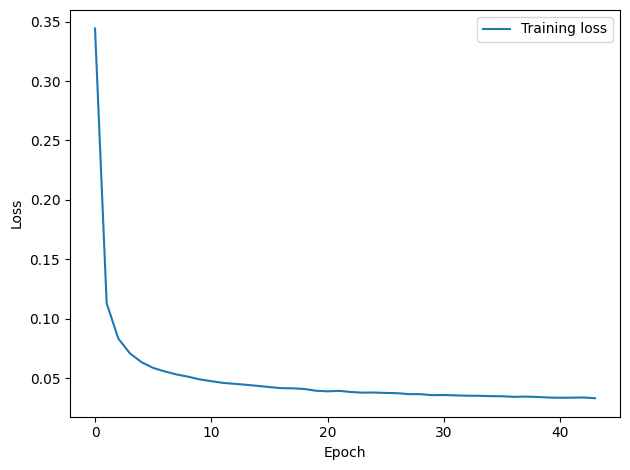

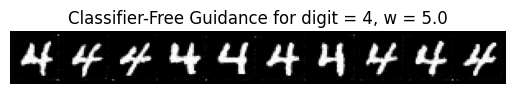

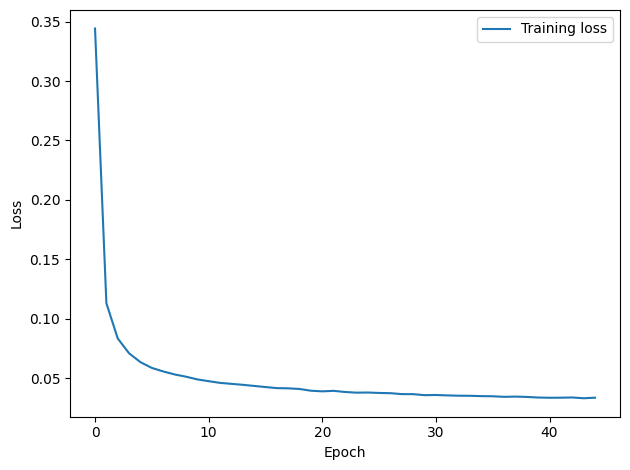

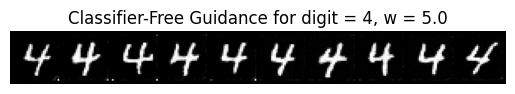

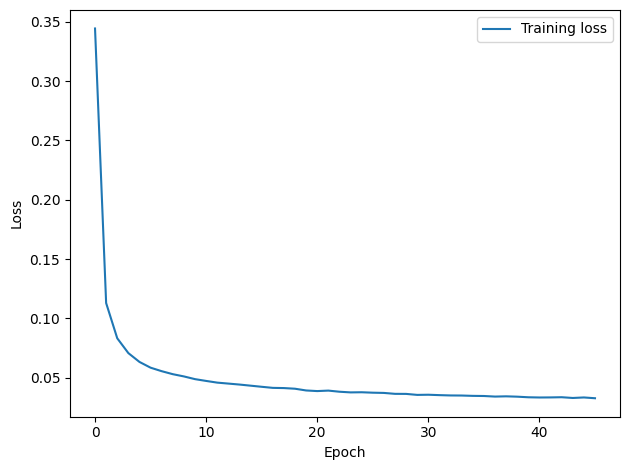

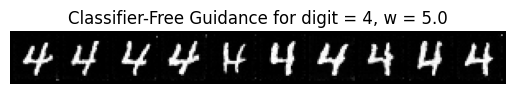

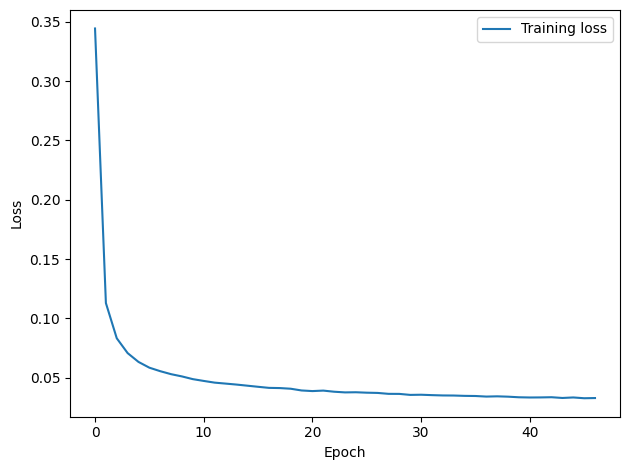

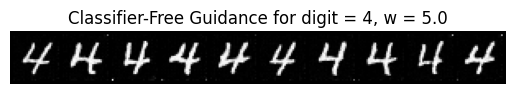

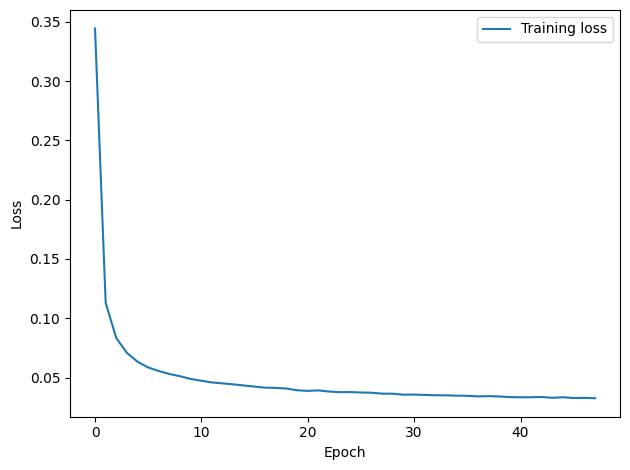

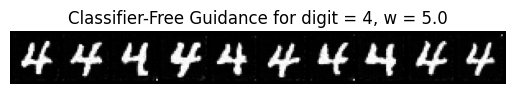

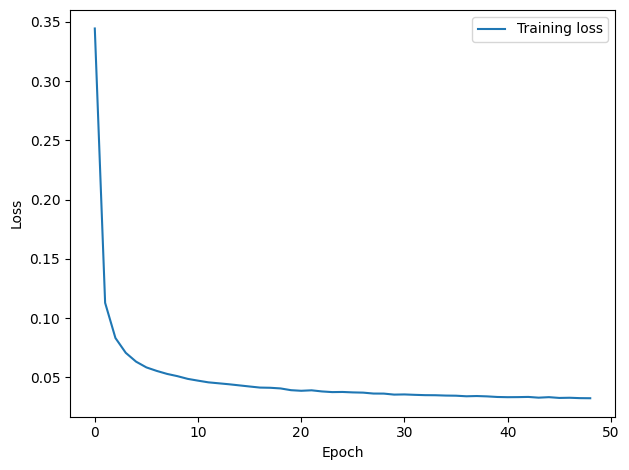

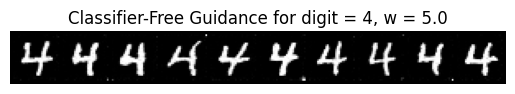

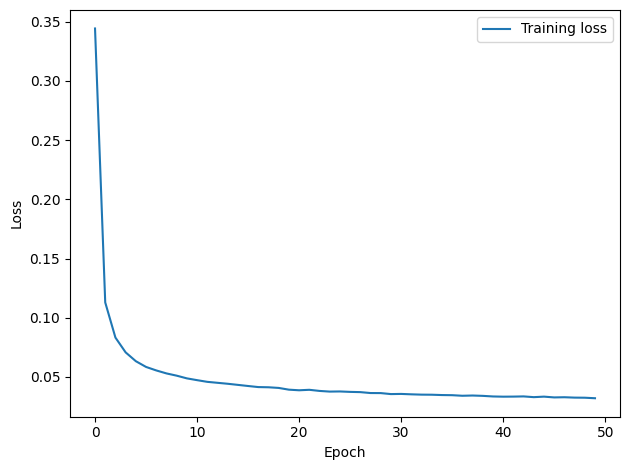

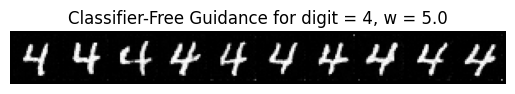

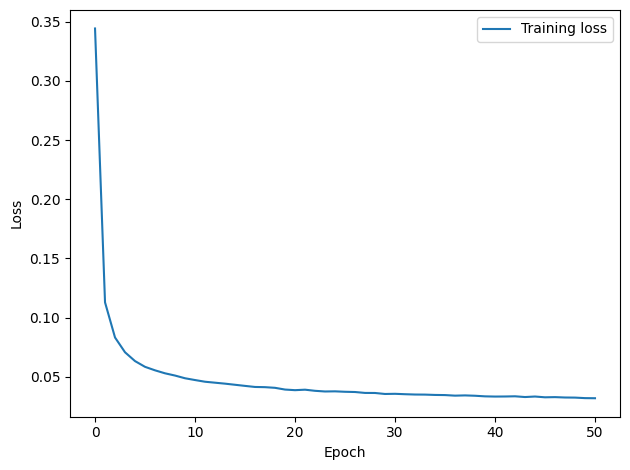

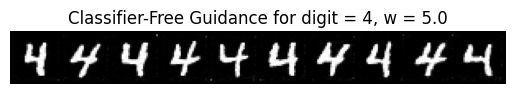

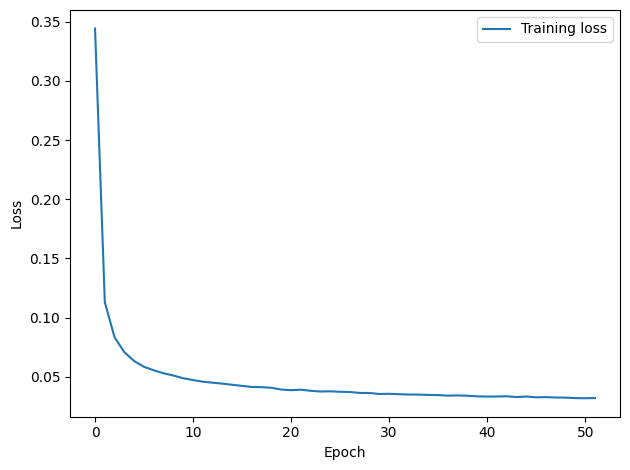

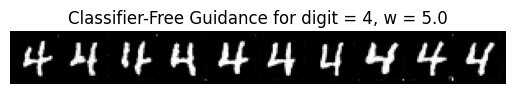

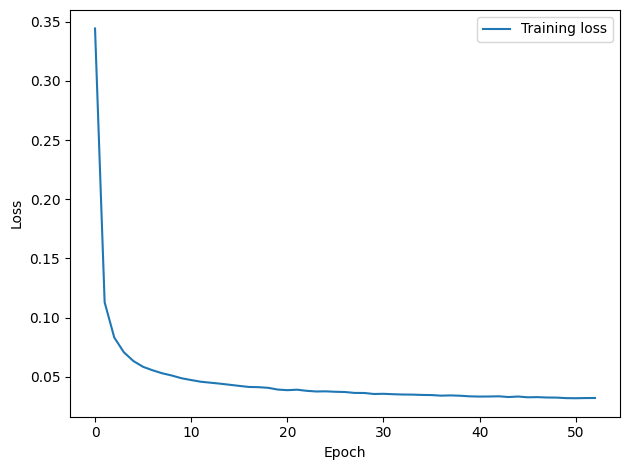

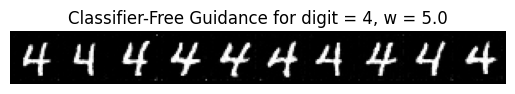

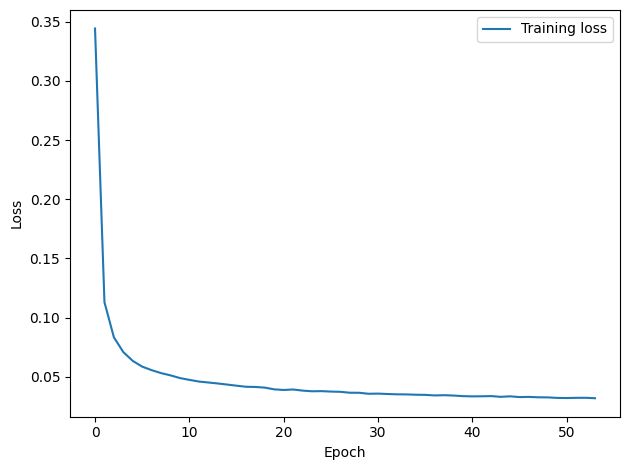

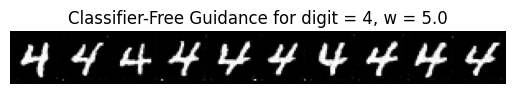

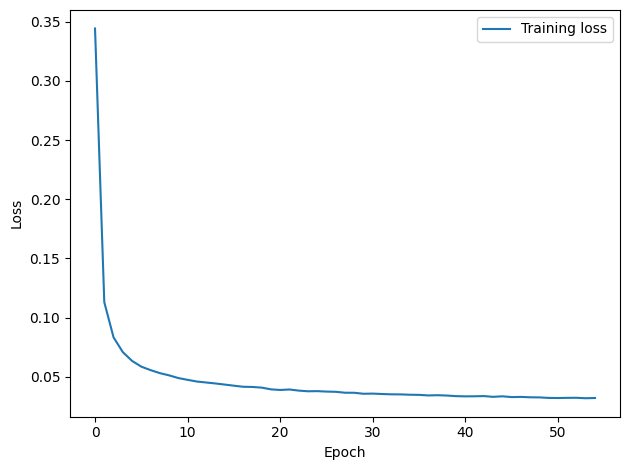

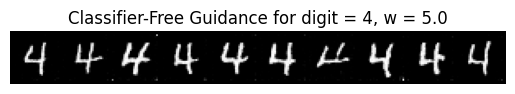

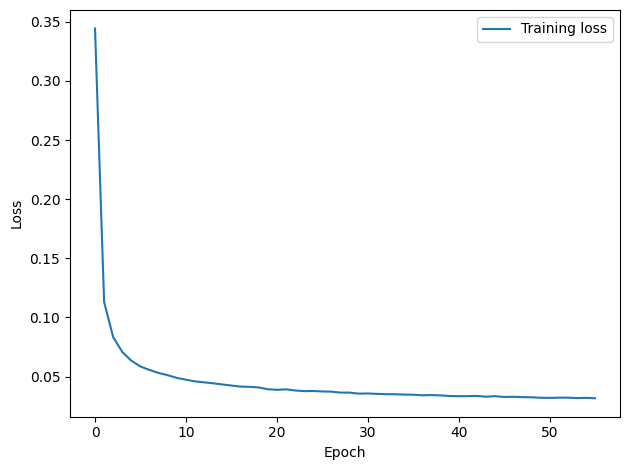

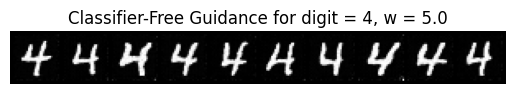

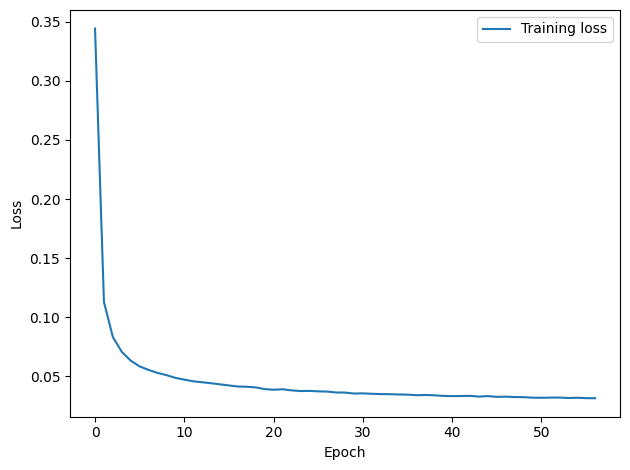

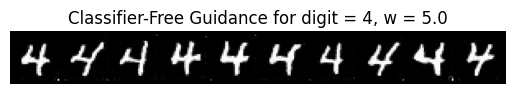

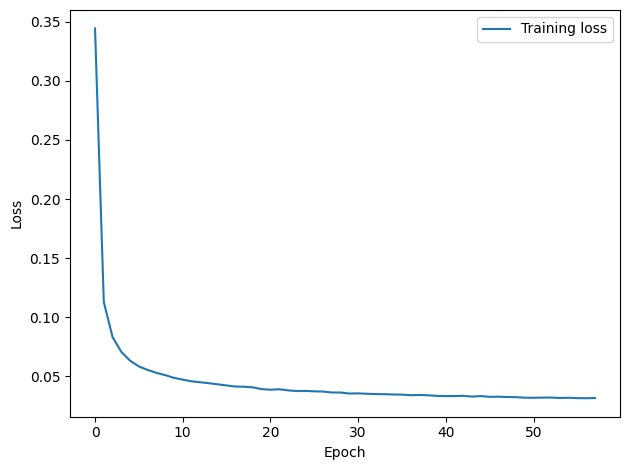

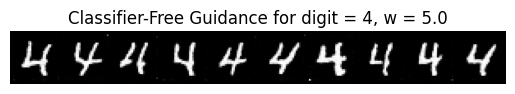

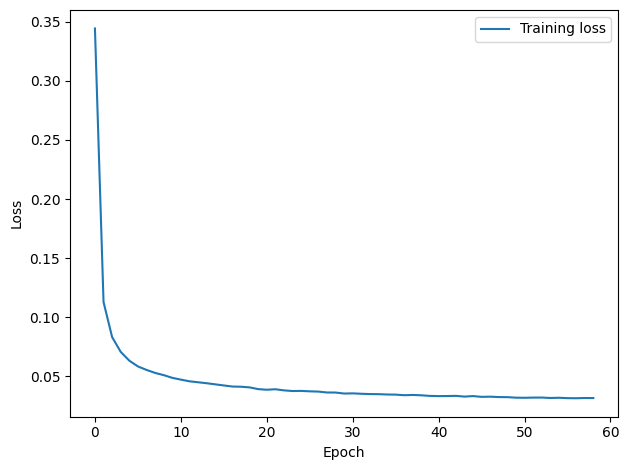

In [ ]:
# class DDPMCGF: DDPM class for Classifier-Free Guidance
class DDPMCFG(nn.Module):
  def __init__(self, network, T = 100, beta_1 = 1e-4, beta_T = 2e-2, w = 5.0):
        """
        Initialize Denoising Diffusion Probabilistic Model for Classifier-Free Guidance

        Parameters
        ----------
        network: ScoreNetCFG
            network expects (x, t, y)
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps
        w:  is a parameter that controls the strength of the classifier guidance,
        so how strongly we push toward the given digit label.
        """
        super().__init__()
        self._network = network # ScoreNetCFG
        # Normalizing time input
        # Reshape input into image format and normalize time value before sending it to network model
        self.network = lambda x, t, y: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T),
                                                      y)
                                    ).reshape(-1, 28*28)
        self.T = T
        self.w = w

        # Defining beta schedule
        beta = torch.linspace(beta_1, beta_T, T+1)
        alpha = 1 - beta
        alpha_bar = alpha.cumprod(dim = 0)
        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", beta)
        self.register_buffer("alpha", alpha)
        self.register_buffer("alpha_bar", alpha_bar)

        # Defining a null label as 10
        self.null_label = 10

  def forward_diffusion(self, x0, t, epsilon):
    '''
    q(x_t | x_0)
    ----------
    x0: torch.tensor
        x value at t=0 (an input image)
    t: int
        step index
    epsilon:
        noise sample

    Returns
    -------
    torch.tensor
        image at timestep t
    '''

    mean = torch.sqrt(self.alpha_bar[t])*x0
    std = torch.sqrt(1 - self.alpha_bar[t])

    return mean + std*epsilon

  def reverse_diffusion(self, xt, t, epsilon, label):
    """
    x_t -> x_{t-1}, using Classifier-Free Guidance:
    Unconditional prediction:
      eps_uncond = net(x_t, t, null_label)
    Conditional prediction:
      eps_cond   = net(x_t, t, label)
    Combined with scalar 'w':
      eps_final  = eps_uncond + w * (eps_cond - eps_uncond)

    Then proceeding with standard DDPM formula for mean + variance.
    """
    y_uncond = torch.full((xt.size(0),), self.null_label, device = xt.device, dtype = torch.long)
    #y_cond = torch.full((shape[0], ), self.null_label, device = xt.device, dtype = torch.long)
    eps_uncond = self.network(xt, t, y_uncond)
    eps_cond = self.network(xt, t, label)
    eps_final = eps_uncond + self.w * (eps_cond - eps_uncond)

    mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*eps_final)
    std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

    return mean + std*epsilon

  @torch.no_grad()
  def sample(self, shape, digit_label):

    # Sample xT: Gaussian noise
    xT = torch.randn(shape).to(self.beta.device)
    xt = xT

    label_tensor = torch.tensor(digit_label, device = self.beta.device)
    label_tensor = label_tensor.expand(shape[0])

    for t in range(self.T, 0, -1):
        noise = torch.randn_like(xT) if t > 1 else 0
        t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
        xt = self.reverse_diffusion(xt, t, noise, label_tensor)

    return xt

  def loss(self, x0, y):
    """
    We randomly set some fraction of y to be a 'null' label
    for unconditional training. Then, we do the usual MSE on epsilon.

    x0: the real image
    y: digit label in [0,...,9]
    """
    fraction = 0.1
    mask_frac = (torch.rand_like(y.float()) < fraction)
    y_ = y.clone()
    # Setting some labels as undonditional, null labels
    y_[mask_frac] = self.null_label

    t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
    epsilon = torch.randn_like(x0)
    xt = self.forward_diffusion(x0, t, epsilon)

    return nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t, y_))

def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
  """
  Training loop

  Parameters
  ----------
  model: nn.Module
      Pytorch model
  optimizer: optim.Optimizer
      Pytorch optimizer to be used for training
  scheduler: optim.LRScheduler
      Pytorch learning rate scheduler
  dataloader: utils.DataLoader
      Pytorch dataloader
  epochs: int
      Number of epochs to train
  device: torch.device
      Pytorch device specification
  ema: Boolean
      Whether to activate Exponential Model Averaging
  per_epoch_callback: function
      Called at the end of every epoch
  """
  # Setup progress bar
  total_steps = len(dataloader)*epochs
  progress_bar = tqdm(range(total_steps), desc="Training")

  if ema:
      ema_global_step_counter = 0
      ema_steps = 10
      ema_adjust = dataloader.batch_size * ema_steps / epochs
      ema_decay = 1.0 - 0.995
      ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
      ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

  train_loss_list = []
  for epoch in range(epochs):
      # Switch to train mode
      model.train()
      epoch_loss_sum = 0.0

      for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = model.loss(x, y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
        progress_bar.update()

        if ema:
            ema_global_step_counter += 1
            if ema_global_step_counter%ema_steps==0:
                ema_model.update_parameters(model)

        # Accumulating loss
        epoch_loss_sum += loss.item()

      # Calculating average loss for the epoch
      avg_loss_epoch = epoch_loss_sum / len(dataloader)
      train_loss_list.append(avg_loss_epoch)

      if per_epoch_callback:
          per_epoch_callback(ema_model.module if ema else model, train_loss_list)

# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256

# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_cfg = ScoreNetCFG((lambda t: torch.ones(1).to(device)), num_classes = 11, label_embed_dim = 64).to(device)

# Construct model
model_cfg = DDPMCFG(mnist_cfg, T=T, beta_1=1e-4, beta_T=2e-2, w=5.0).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model_cfg.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

def reporter(digit):
    """Callback function used for plotting images during training"""
    def callback_fn(model, train_loss_list):
      # Switch to eval mode
      model.eval()

      with torch.no_grad():
          nsamples = 10
          samples = model.sample((nsamples,28*28), digit_label = digit).cpu()

          # Map pixel values back from [-1,1] to [0,1]
          samples = (samples+1)/2
          samples = samples.clamp(0.0, 1.0)

          # Plot in grid
          grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
          plt.gca().set_axis_off()
          plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
          plt.title(f"Classifier-Free Guidance for digit = {digit}, w = {model.w}")
          plt.show()

      # Plotting the training-loss curve
      plt.plot(figsize = (6,6))
      plt.plot(train_loss_list, label = "Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend()
      plt.tight_layout()
      plt.show()

    return callback_fn

ema_model = train(model_cfg, optimizer, scheduler, dataloader_train, epochs = epochs, device = device, ema = True, per_epoch_callback = reporter( digit =4))
final_model = ema_model.module if ema_model else model_cfg
final_model.eval()

In [ ]:
# Sampling digit 4 after training
digit = 4

with torch.no_grad():
  nsamples = 10
  samples = final_model.sample((nsamples,28*28), digit_label = digit).cpu()

  # Map pixel values back from [-1,1] to [0,1]
  samples = (samples+1)/2
  samples = samples.clamp(0.0, 1.0)

  # Plot in grid
  grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
  plt.gca().set_axis_off()
  plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
  plt.title(f"Classifier-Free Guidance for digit = {digit}, w = {model.w}")
  # plt.axis('off')
  plt.show()